In [ ]:
!pip3 install numpy
!pip3 install matplotlib
!pip3 install pandas

!pip3 install opencv-python

!pip3 install torch torchvision torchaudio

!pip3 install tensorflow
!pip3 install keras
!pip3 install tensorflow

!pip3 install gTTS
!pip3 install librosa
# !pip3 install soundfile

In [1]:
from random import random
import time
import os
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split

import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# from torch.utils.data import Dataset
# from torchvision.io import read_image
# from torch.utils.data import DataLoader
# import torchvision.transforms as transforms
# import torch.nn as nn
# import torch.nn.functional as F

from gtts import gTTS # for text-to-speech
# import soundfile as sf
from IPython.display import Audio
import librosa
import librosa.effects

In [2]:
# Make plots larger (default [6,4] on my machine)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [12, 8]
# print(mpl.rcParams['figure.figsize'])

## Data Pre-Processing

In [3]:
# Data Directory

datadir = "data/samples/"
# datadir = "data/"
# print(os.listdir(datadir + "/samples") == os.listdir(datadir))

In [4]:
# Get images from data directory
num_images = len(os.listdir(datadir))
print(num_images)

1070


In [5]:
img_paths = list()
characters = set()
captcha_length = []

for img_name in os.listdir(datadir):
  if len(img_name.split(".")) > 1:
    img_path = os.path.join(datadir, img_name)
    label, format = img_name.split(".")
    if format == "png":
      img_paths.append(img_path)

captcha_labels_train = list()
for img_name in os.listdir(datadir):
  if len(img_name.split(".")) > 1:
    label, format = img_name.split(".")
    if format == "png":
      captcha_labels_train.append(label)
      captcha_length.append(len(label))
      for ch in label:
        characters.add(ch)

characters = sorted(characters)

In [6]:
img_label_lst = list(zip(img_paths, captcha_labels_train))
img_label_df = pd.DataFrame(img_label_lst, columns=["img_path", "label"])
img_label_df = img_label_df.sample(frac=1.).reset_index(drop=True)
# dataset.head()
len(img_label_df)

1040

### Removing Blur and Sharpening Images

(Optional)

In [7]:
print(img_label_df[img_label_df['label'] == '8n4n8'])
print(img_label_df.iloc[[0]]['img_path'])
testvar1234 = img_label_df['img_path'].values[0] # (img_label_df.iloc[[0]])['img_path']
print(testvar1234)
print(type(testvar1234))

                   img_path  label
364  data/samples/8n4n8.png  8n4n8
0    data/samples/b4y5x.png
Name: img_path, dtype: object
data/samples/b4y5x.png
<class 'str'>


##### Original images for comparison

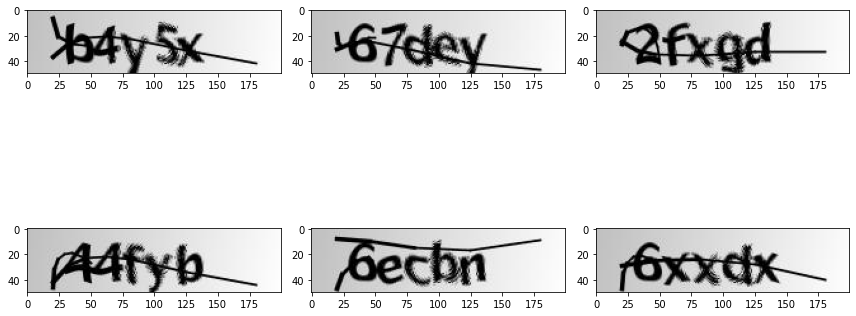

In [8]:
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols)

row = 0
for img_idx in range(0, 6, 1):
    # print(img_paths[img_index].shape)
    img = cv2.imread(img_label_df['img_path'].values[img_idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img_idx % 3 == 0 and img_idx != 0:
        row += 1
    axes[row, img_idx % num_cols].imshow(img)
    # axes[row, img_index % num_cols].set_title(captcha_labels_train[img_index])

fig.tight_layout()
plt.show()

##### Sharpened, Denoised Images

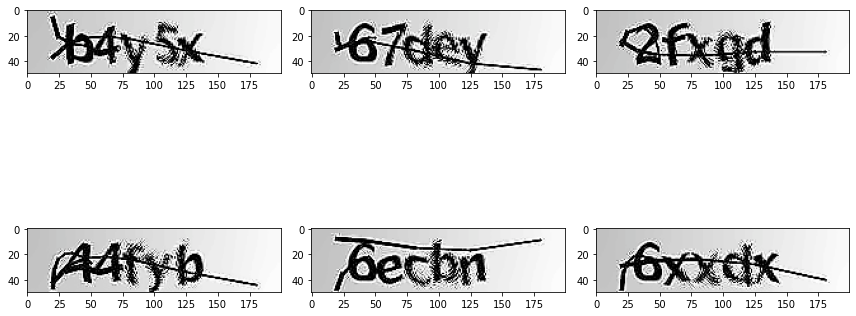

In [9]:
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols)

row = 0
for img_idx in range(0, 6, 1):
    img = cv2.imread(img_label_df['img_path'].values[img_idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)

    sharpen_kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    sharpened_image = cv2.filter2D(img, -1, sharpen_kernel)
    sharpened_image = cv2.fastNlMeansDenoisingColored(sharpened_image,None,10,10,7,21)

    if img_idx % 3 == 0 and img_idx != 0:
        row += 1
    axes[row, img_idx % num_cols].imshow(sharpened_image)
    # axes[row, img_idx % num_cols].set_title(captcha_labels_train[img_idx])

fig.tight_layout()
plt.show()

### Sharpen and denoise full dataset (Please run this cell once only)

In [ ]:
for img_idx in range(len(img_label_df)):
    path = img_label_df['img_path'].values[img_idx]
    img = cv2.imread(path)
    label = img_label_df['label'].values[img_idx]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)

    # Sharpen kernel
    sharpen_kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    sharpened_image = cv2.filter2D(img, -1, sharpen_kernel)

    # Denoising
    final_image = cv2.fastNlMeansDenoisingColored(sharpened_image,None,10,10,7,21)

    cv2.imwrite(path, final_image)

## CRNN Model

In [10]:
seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

training_data = img_label_df.sample(frac=0.8)
val_data = img_label_df.drop(training_data.index)

print("Number of training samples: ", len(training_data))
print("Number of validation samples: ", len(val_data))

unique_characters = list()

for label in captcha_labels_train:
  for char in label:
    if char not in unique_characters:
      unique_characters.append(char)

unique_characters.sort()

char_to_int = dict()
int_to_char = dict()

for index, char in enumerate(unique_characters):
  char_to_int[char] = index
  int_to_char[index] = char

def store_data_as_np_arrays(dataframe: pd.DataFrame, image_height: int, image_width: int, resize: bool):
  num_images = len(dataframe)
  images_as_array = np.zeros((num_images, 50, 200))
  labels_as_list = ['a']*num_images

  counter = 0
  for index, row in dataframe.iterrows():
    img_path = row["img_path"]
    label = row["label"]

    if (datadir + "samples") != img_path:

      image = cv2.imread(img_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

      if resize:
        image = cv2.resize(image, (image_width, image_height))

      images_as_array[counter] = (image/255.0).astype(np.float32)
      labels_as_list[counter] = label

      counter += 1
    
  labels_as_list = np.array(labels_as_list)
  return images_as_array, labels_as_list

# Build training data
training_data, training_labels = store_data_as_np_arrays(training_data, image_height = 50, image_width = 200, resize = True)
print("Number of training images: ", training_data.shape)
print("Number of training labels: ", training_labels.shape)

# Build validation data
validation_data, validation_labels = store_data_as_np_arrays(val_data, image_height = 50, image_width = 200, resize = True)
print("Number of validation images: ", validation_data.shape)
print("Number of validation labels: ", validation_labels.shape)

Number of training samples:  832
Number of validation samples:  208
Number of training images:  (832, 50, 200)
Number of training labels:  (832,)
Number of validation images:  (208, 50, 200)
Number of validation labels:  (208,)


In [11]:
class DataGenerator(keras.utils.Sequence):
    """Generates batches from a given dataset.
    
    Args:
        data: training or validation data
        labels: corresponding labels
        char_map: dictionary mapping char to labels
        batch_size: size of a single batch
        img_width: width of the resized
        img_height: height of the resized
        downsample_factor: by what factor did the CNN downsample the images
        max_length: maximum length of any captcha
        shuffle: whether to shuffle data or not after each epoch
    Returns:
        batch_inputs: a dictionary containing batch inputs 
        batch_labels: a batch of corresponding labels 
    """
    
    def __init__(self, data,
                 labels,
                 char_map,
                 batch_size=16,
                 img_width=200, img_height=50,
                 downsample_factor=4, max_length=5,
                 shuffle=True
                ):
        self.data = data
        self.labels = labels
        self.char_map = char_map
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.downsample_factor = downsample_factor
        self.max_length = max_length
        self.shuffle = shuffle
        self.indices = np.arange(len(data))    
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, idx):
        # 1. Get the next batch indices
        curr_batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        
        # 2. This isn't necessary but it can help us save some memory
        # as not all batches the last batch may not have elements
        # equal to the batch_size 
        batch_len = len(curr_batch_idx)
        
        # 3. Instantiate batch arrays
        batch_images = np.ones((batch_len, self.img_width, self.img_height, 1), dtype=np.float32)
        batch_labels = np.ones((batch_len, self.max_length), dtype=np.float32)
        input_length = np.ones((batch_len, 1), dtype=np.int64) * (self.img_width // self.downsample_factor - 2)
        label_length = np.zeros((batch_len, 1), dtype=np.int64)
        
        
        for j, idx in enumerate(curr_batch_idx):
            # 1. Get the image and transpose it
            img = self.data[idx].T
            # 2. Add extra dimenison
            img = np.expand_dims(img, axis=-1)
            # 3. Get the correpsonding label
            text = self.labels[idx]
            # 4. Include the pair only if the captcha is valid
            # if is_valid_captcha(text):
            label = [self.char_map[ch] for ch in text]
            batch_images[j] = img
            batch_labels[j] = label
            label_length[j] = len(text)
    
        batch_inputs = {
                'input_data': batch_images,
                'input_label': batch_labels,
                'input_length': input_length,
                'label_length': label_length,
                }
        return batch_inputs, np.zeros(batch_len).astype(np.float32)
        
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [12]:
# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width=200
img_height=50 

# Factor  by which the image is going to be downsampled
# by the convolutional blocks
downsample_factor=4

# Maximum length of any captcha in the data
max_length=5

# Get a generator object for the training data
train_data_generator = DataGenerator(data=training_data,
                                     labels=training_labels,
                                     char_map=char_to_int,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=True
                                    )

# Get a generator object for the validation data 
valid_data_generator = DataGenerator(data=validation_data,
                                     labels=validation_labels,
                                     char_map=char_to_int,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=False
                                    )

In [13]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return loss



def build_model():
    # Input layers: refer
    input_img = layers.Input(shape=(img_width, img_height, 1), name='input_data', dtype='float32')
    
    labels = layers.Input(name='input_label', shape=[max_length], dtype='float32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int64')
    
    # Convolutional Block 1
    x = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same',               name='Conv1')(input_img)
    x = layers.MaxPooling2D((2,2), name='pool1')(x)
    
    # Convolutional Block 2
    x = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same', name='Conv2')(x)
    x = layers.MaxPooling2D((2,2), name='pool2')(x)

    new_shape = ((img_width // 4), (img_height // 4)*64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)
    
    # RNN Layers
    x = layers.Bidirectional(layers.LSTM(128,
                                         return_sequences=True,
                                         dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(64,
                                         return_sequences=True,
                                         dropout=0.25))(x)
    
    # Predictions
    x = layers.Dense(len(unique_characters)+1,activation='softmax', name='dense2',kernel_initializer='he_normal')(x)
    
    # Calculate CTC
    output = CTCLayer(name='ctc_loss')(labels, x, input_length, label_length)
    
    # Define the model
    model = keras.models.Model(inputs=[input_img, labels, input_length, label_length], outputs=output, name='ocr_model_v1')
    
    # Optimizer
    '''
    Note:
        Using the legacy Optimizer since the current optimizer runs slow on M1. TensorFlow throws the following warnings:
            WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.SGD` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.SGD`.
            WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.SGD`.
    '''
    sgd = keras.optimizers.legacy.SGD(learning_rate=0.002, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    
    # Compile the model and return 
    model.compile(optimizer=sgd)
    return model

In [14]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_data (InputLayer)     [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['input_data[0][0]']          
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                       

In [15]:
# Add early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   patience=5,
                                   restore_best_weights=True)

# Train the model
history = model.fit(train_data_generator,
                    validation_data=valid_data_generator,
                    epochs=50,
                    callbacks=[es])

Epoch 1/50
52/52 [==============================] - 8s 103ms/step - loss: 25.8728 - val_loss: 16.4614
Epoch 2/50
52/52 [==============================] - 5s 99ms/step - loss: 16.3599 - val_loss: 16.4905
Epoch 3/50
52/52 [==============================] - 5s 106ms/step - loss: 16.2654 - val_loss: 16.1788
Epoch 4/50
52/52 [==============================] - 6s 109ms/step - loss: 16.1636 - val_loss: 16.0086
Epoch 5/50
52/52 [==============================] - 6s 117ms/step - loss: 16.1092 - val_loss: 15.9771
Epoch 6/50
52/52 [==============================] - 5s 104ms/step - loss: 16.0728 - val_loss: 15.9223
Epoch 7/50
52/52 [==============================] - 5s 100ms/step - loss: 16.0404 - val_loss: 15.8762
Epoch 8/50
52/52 [==============================] - 5s 93ms/step - loss: 16.0226 - val_loss: 15.8881
Epoch 9/50
52/52 [==============================] - 5s 100ms/step - loss: 16.0000 - val_loss: 15.8248
Epoch 10/50
52/52 [==============================] - 5s 95ms/step - loss: 15.9175 - 

In [16]:
prediction_model = keras.models.Model(model.get_layer(name='input_data').input,
                                        model.get_layer(name='dense2').output)
prediction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_data (InputLayer)     [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

In [17]:
# A utility to decode the output of the network
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, 
                                        input_length=input_len,
                                        greedy=True)[0][0]
    
    # Iterate over the results and get back the text
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += int_to_char[c]
        output_text.append(outstr)
    
    # return final text results
    return output_text

In [18]:
#  Let's check results on some validation sample
for p, (inp_value, _) in enumerate(valid_data_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']

    # # print(X_data[1].shape)
    # plt.imshow(X_data[1], cmap='gray')
    # plt.show()
    # # sample_to_test = X_data[0]
    # print(X_data[1].shape)
    # # print(X_data[1])

    # preds = prediction_model.predict(np.reshape(X_data[1], (1, 200, 50, 1)))
    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)
    # print(preds)
    print(pred_texts)
    
    orig_texts = []
    for label in labels:
        text = ''.join([int_to_char[int(x)] for x in label])
        orig_texts.append(text)
        
    for i in range(bs):
        print(f'Actual label: {orig_texts[i]} \t Predicted label: {pred_texts[i]}')
    break

1/1 [==============================] - 1s 616ms/step
['67dey', '44fyb', '6ecbn', 'cm6yb', 'n2gmg', 'g7fmc', 'ny5dp', 'n7dyb', 'pyf65', 'pym7p', 'd8dce', '478nx', 'p2x7x', 'w2e87', 'bf52c', 'n3bm6']
Actual label: 67dey 	 Predicted label: 67dey
Actual label: 44fyb 	 Predicted label: 44fyb
Actual label: 6ecbn 	 Predicted label: 6ecbn
Actual label: cm6yb 	 Predicted label: cm6yb
Actual label: n2gmg 	 Predicted label: n2gmg
Actual label: g7fmc 	 Predicted label: g7fmc
Actual label: ny5dp 	 Predicted label: ny5dp
Actual label: n7dyb 	 Predicted label: n7dyb
Actual label: pyf65 	 Predicted label: pyf65
Actual label: pym7p 	 Predicted label: pym7p
Actual label: d8dce 	 Predicted label: d8dce
Actual label: 478nx 	 Predicted label: 478nx
Actual label: p2x7x 	 Predicted label: p2x7x
Actual label: w2e87 	 Predicted label: w2e87
Actual label: bf52c 	 Predicted label: bf52c
Actual label: n3bm6 	 Predicted label: n3bm6


### Process User Input

In [19]:
def resizeImage(cv2img):
    '''
    Input:
        Original CAPTCHA CV2 image
    Returns
        Image resized to (200, 50)
    Notes:
        Our model can only accept images of a certain shape, hence we need to resize them
        Resizing may be linear but will often involve changing the ratio of width to height:
            Different factor of shrinkage/enlargement along the 2 axes
        INTER_AREA interpolation works best for shrinking images
        INTER_CUBIC interpolation works well when enlarging images
    '''
    if cv2img.shape[1] > 200: # then we need to shrink image
        return cv2.resize(cv2img, (200, 50), interpolation = cv2.INTER_AREA)
    else: # then we need to enlarge image
        return cv2.resize(cv2img, (200, 50), interpolation = cv2.INTER_CUBIC)


def sharpenImage(cv2img):
    '''
    Input:
        Original CAPTCHA CV2 image
    Returns:
        Sharpened and denoised image
    '''
    cv2img = cv2.cvtColor(cv2img, cv2.COLOR_BGR2RGB)
    # img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)

    sharpen_kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    sharpened_image = cv2.filter2D(cv2img, -1, sharpen_kernel)
    sharpened_image = cv2.fastNlMeansDenoisingColored(sharpened_image,None,10,10,7,21)

    return sharpened_image

### Convert CAPTCHA Image to Text Based on Trained Model

In [27]:
def detectCaptchaText(path:str, resize:bool=True, sharpen:bool=False):
    captcha_img = cv2.imread(path)

    if sharpen:
        captcha_img = sharpenImage(captcha_img)
    if resize:
        captcha_img = resizeImage(captcha_img)

    captcha_img = cv2.cvtColor(captcha_img, cv2.COLOR_BGR2GRAY) # convert to grayscale to reduce channels from 3 to 1
    
    captcha_img = captcha_img.T # transpose since we need to pass in (1, 200, 50, 1) to model. This step gets us to (200, 50)
    captcha_img = np.divide(captcha_img, 255) # need 0...255 int values scaled to 0...1 float values
    captcha_img = np.expand_dims(captcha_img, axis=-1) # shape (200, 50) --> (200, 50, 1)

    prediction = prediction_model.predict(np.reshape(captcha_img, (1, 200, 50, 1)))
    prediction_text = decode_batch_predictions(prediction)
    
    return prediction_text[0]

In [28]:
path = datadir + '2b827.png'
# path = '/Users/arhangoyal/Downloads/img3.png'
detectCaptchaText(path, sharpen=True)

1/1 [==============================] - 0s 12ms/step


'2b827'

## Text-to-Speech

### Hugging Face Version (Not Using)

In [22]:
# from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan
# from datasets import load_dataset
# import torch
# import soundfile as sf

# processor = SpeechT5Processor.from_pretrained('microsoft/speecht5_tts')
# model = SpeechT5ForTextToSpeech.from_pretrained('microsoft/speecht5_tts')
# vocoder = SpeechT5HifiGan.from_pretrained('microsoft/speecht5_hifigan')

# # inputs = processor(text="Work you stupid piece of crap", return_tensors="pt")
# inputs = processor(text="C.", return_tensors="pt")

# embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
# speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

# speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

# from IPython.display import Audio

# Audio(speech, rate=12000)
# # sf.write("testAudio.wav", speech.numpy())

### GTTS Version

In [23]:
def label2cleanSpeech(captcha_label:str, out_filename:str="captchaAudioClean.wav", language:str='en'):
    '''
    Input:
        captcha_label: string to convert to audio
        out_filename : file (with path) to save audio (.wav) file to
                     : "captchaAudioClean.wav" by default
        language     : language of text/audio
                     : "en" for English by default
    Returns:
        speech_obj   : gTTS audio object
    '''
    txt = ""
    for character in captcha_label:
        txt += character + "/"
    speech_obj = gTTS(text=txt, lang=language, slow=True) # slow=True for speech to be slow
    speech_obj.save(out_filename)

    return speech_obj


def cleanSpeech2captchaAudio(in_filename:str="captchaAudioClean.wav", out_filename:str="captchaAudioFinal.wav"):
    '''
    Input:
        in_filename  : file (with path: .wav or .mp3) to add noise to
                     : "captchaAudioClean.wav" by default
        out_filename : file (with path) to save final noisy captcha audio (.wav) file to
                     : "captchaAudioFinal.wav" by default
    Returns:
        Audio with pitch shift, noise, and stretch applied
    '''

    original_audio, sr = librosa.load(in_filename, sr=None)

    # Pitch shift
    pitch_shifted_audio = librosa.effects.pitch_shift(original_audio, sr=sr, n_steps=1.0)

    # Add Wald (inverse Gaussian) noise
    noise_audio = pitch_shifted_audio.copy()
    noise_amp = 0.005*np.random.wald(30,2)*np.amax(noise_audio)
    noise_audio = noise_audio.astype('float64') + noise_amp * np.random.normal(size=noise_audio.shape[0])

    # Stretch Audio
    input_length = len(noise_audio)
    stretch_audio = noise_audio.copy()
    stretch_audio = librosa.effects.time_stretch(stretch_audio.astype('float'), rate=1.1)
    if len(stretch_audio) > input_length:
        stretch_audio = stretch_audio[:input_length]
    else:
        stretch_audio = np.pad(stretch_audio, (0, max(0, input_length - len(stretch_audio))), "constant")

    # Audio at 80% of sampling rate
    final_audio = Audio(stretch_audio, rate=0.8*sr)
    # sf.write(out_filename, data=stretch_audio, samplerate=int(sr*0.8), subtype='PCM_24')
    with open(out_filename, 'wb') as f:
        f.write(final_audio.data)
    return final_audio

In [24]:
label2cleanSpeech("CN8p4")
cleanSpeech2captchaAudio()

## Command Line Interface

In [29]:
import cmd

class captcha2audioCLI(cmd.Cmd):
    prompt = '>> '
    intro = '''>> Welcome to our CAPTCH to Audio Convertor.\n   Please a full path to the captcha image. Type "help" for available commands.\n'''

    # Help
    def do_help(self, line):
        print(">> Please enter a pathname.\n   Example: /Users/user/Downloads/filename.png")
        print('''   Other commands:\n     - "q" or "quit" to exit''')
    
    # Read CAPTCHA image
    def do_image(self, line):
        while True:
            path = input("Please enter captcha image (full path): ")
            if path in ('quit', 'q', 'exit'):
                break
            try:
                # img = cv2.imread(path)
                # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # plt.imshow(img)
                print(detectCaptchaText(path))
                break
            except:
                print("File does not exist. Please enter a valid path.")
    
    # Post command hook: empty line for better readability
    def postcmd(self, stop, line):
        print()
        return stop
    
    # Quit
    def do_quit(self, line):
        return True
    def do_q(self, line):
        return True
    def do_exit(self, line):
        return True

if __name__ == '__main__':
    captcha2audioCLI().cmdloop()

>> Welcome to our CAPTCH to Audio Convertor.
   Please a full path to the captcha image. Type "help" for available commands.

>> Please enter a pathname.
   Example: /Users/user/Downloads/filename.png
   Other commands:
     - "q" or "quit" to exit



[ WARN:0@499.004] global loadsave.cpp:248 findDecoder imread_('data/sampels/2b827.png'): can't open/read file: check file path/integrity


File does not exist. Please enter a valid path.
1/1 [==============================] - 0s 20ms/step
2b827


